# Homework 5
## Sungwon Lee
### 017473950

# Part 1

## Step 1.

In [1]:
# load Fashion MNIST
import torch
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

In [2]:
fashion_mnist = FashionMNIST(root='data', train=True, download=True, \
                             transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))
                             

In [3]:
img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:, 10:15, 10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

Label:  9


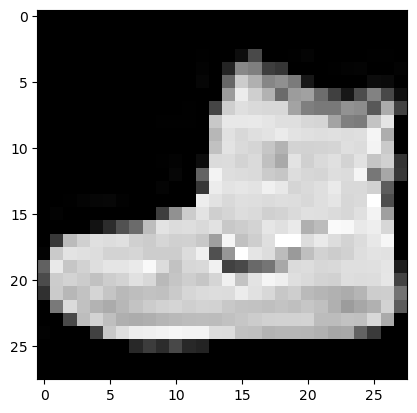

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(x):
    out = (x+1)/2
    return out.clamp(0, 1)

img_norm = denorm(img)

plt.imshow(img_norm[0], cmap='gray')
print('Label: ', label)

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 7, 5, 9, 0, 7, 6, 1, 5, 2, 6, 3, 1, 9, 4, 4, 1, 8, 6, 6, 7, 8, 0, 2,
        5, 6, 6, 9, 4, 1, 5, 9, 6, 9, 7, 2, 9, 4, 1, 8, 3, 0, 0, 7, 7, 5, 2, 7,
        0, 2, 7, 6, 8, 6, 9, 6, 2, 0, 0, 6, 8, 8, 6, 6, 5, 4, 3, 4, 0, 7, 9, 7,
        9, 9, 9, 2, 8, 6, 5, 3, 6, 5, 3, 9, 2, 3, 5, 1, 7, 4, 9, 6, 5, 5, 3, 0,
        5, 0, 9, 1])


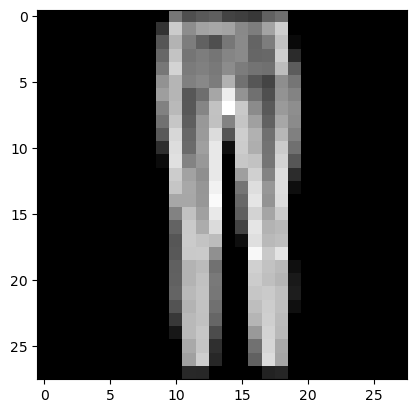

In [6]:
# create dataloader

from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [7]:
# use gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

Discriminator Network

In [8]:
image_size = 784
hidden_size = 256

In [9]:
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);

Generator Network

In [10]:
latent_size = 64

In [11]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

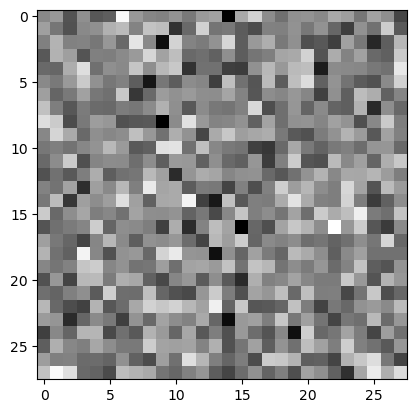

In [12]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())
plt.imshow(gen_imgs[0], cmap='gray')  

## Step 2. Training

Generator Training

In [13]:
G.to(device);

In [14]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [15]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create labels which are be used for later input for the BCE Loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Discriminator(real) image loss
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Generator(fake) image loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # combine loss
    d_loss = d_loss_real + d_loss_fake

    reset_grad()

    # compute gradients
    d_loss.backward()

    # Adjust parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

Generator Training

In [16]:
def train_generator():
    # generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Training the model

In [17]:
import os

sample_dir = "samples"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

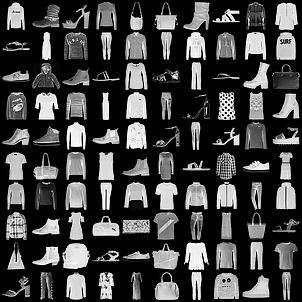

In [18]:
# saving real images
from IPython.display import Image
from torchvision.utils import save_image

for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, "images.png"), nrow=10)
    break

Image(os.path.join(sample_dir, "images.png"))

In [19]:
images.shape
len(data_loader)

600

In [20]:
# save generated images batch for every epoch
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

Saving fake_images-0000.png


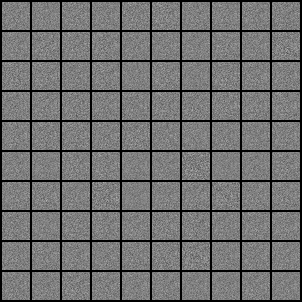

In [21]:
# before training

save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

TRAINING EACH EPOCH

In [21]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # load batch, transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # train D and G
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_image = train_generator()

        # inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], d_loss: {d_loss.item():.4f},\
                    g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, \
                    D(G(z)): {fake_score.mean().item():.2f}")


    save_fake_images(epoch + 1)


Epoch [0/300], Step [200/600], d_loss: 0.1225,                    g_loss: 3.9006, D(x): 0.97,                     D(G(z)): 0.08
Epoch [0/300], Step [400/600], d_loss: 0.2487,                    g_loss: 5.2134, D(x): 0.94,                     D(G(z)): 0.07
Epoch [0/300], Step [600/600], d_loss: 0.0370,                    g_loss: 4.7366, D(x): 0.99,                     D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0540,                    g_loss: 4.5081, D(x): 0.98,                     D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.0655,                    g_loss: 3.6211, D(x): 0.99,                     D(G(z)): 0.05
Epoch [1/300], Step [600/600], d_loss: 0.0248,                    g_loss: 5.2630, D(x): 0.99,                     D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0207,                    g_loss: 5.5578, D(x): 1.00,                     D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0235,  

## Step 3. Display Image and describe difficulites

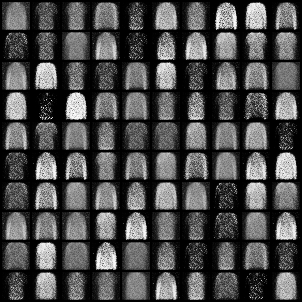

In [23]:
Image('./samples/fake_images-0010.png')

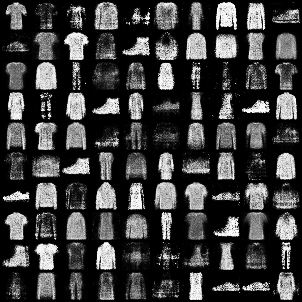

In [24]:
Image('./samples/fake_images-0100.png')

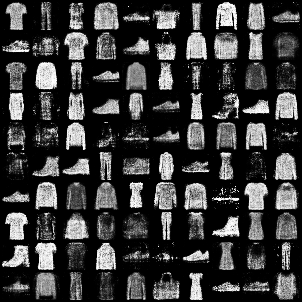

In [25]:
Image('./samples/fake_images-0200.png')

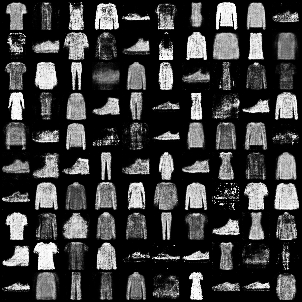

In [26]:
Image('./samples/fake_images-0300.png')

As we monitor the saved fake images at each batch point, it is evident that the quality of the images improves as the epochs progress. However, we also notice that, at certain epochs, the differences in image quality become less pronounced. For instance, when comparing the fake images generated at the 200th epoch and the 300th epoch, the enhancements appear subtle, making it challenging to discern significant improvements between these two points in the training process.



In [28]:
import cv2
import os
from IPython.display import FileLink

vid_frame = 'gans_training_fashionMnist.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_frame, cv2.VideoWriter_fourcc(*'MP4V'), 8, (302, 302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training_fashionMnist.avi')

C:\Users\pumad\OneDrive\문서\SJSU\Fall2024\DATA255\homework5\gans_training_fashionMnist.avi

## Step 4. Save weight

In [28]:
import torch

def save_weight(model, model_name):
    filename = f"{model_name}_weight.pth"
    torch.save(model.state_dict(), filename)
    print(f"Saved {model_name} weight")

save_weight(G, "Generator")
save_weight(D, "Discriminator")

Saved Generator weight
Saved Discriminator weight


## Step 5. Load model

In [22]:
# Load the model weights
def load_weight(model, model_name):
    filename = f"{model_name}_weight.pth"
    model.load_state_dict(torch.load(filename))
    print(f"Loaded {model_name} weight")

load_weight(G, "Generator")
load_weight(D, "Discriminator")


Loaded Generator weight
Loaded Discriminator weight


C:\Users\pumad\AppData\Local\Temp\ipykernel_21560\3317410832.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


## Step 6. Retrain Gan to improve

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [33]:
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0001)  # Try a lower learning rate
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0001)  # Try a lower learning rate

In [34]:
def train_generator_feature_matching():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    
    # Use feature matching from the discriminator
    real_features = D(images)
    fake_features = D(fake_images)
    
    g_loss = criterion(fake_features, real_features.detach())  
    
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images


In [42]:
def train_discriminator_with_noise(images):
    noise = torch.randn_like(images) * 0.1  # Gaussian noise
    noisy_images = images + noise
    
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(noisy_images)
    d_loss_real = criterion(outputs, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)

    # Combine losses
    d_loss = d_loss_real + d_loss_fake

    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, outputs, outputs.detach()  

In [47]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images_modified(index, save_dir="modified_samples"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(save_dir, fake_fname), nrow=10)

In [49]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # load batch, transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # train D and G
        d_loss, real_score, fake_score = train_discriminator_with_noise(images)
        g_loss, fake_image = train_generator_feature_matching()

        # inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))


    save_fake_images_modified(epoch + 1)


Epoch [0/300], Step [200/600], d_loss: 1.0675, g_loss: 0.8904, D(x): 0.35, D(G(z)): 0.35
Epoch [0/300], Step [400/600], d_loss: 1.1916, g_loss: 0.8376, D(x): 0.38, D(G(z)): 0.38
Epoch [0/300], Step [600/600], d_loss: 0.9992, g_loss: 0.9031, D(x): 0.38, D(G(z)): 0.38
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.9615, g_loss: 0.9465, D(x): 0.32, D(G(z)): 0.32
Epoch [1/300], Step [400/600], d_loss: 1.1491, g_loss: 0.9623, D(x): 0.37, D(G(z)): 0.37
Epoch [1/300], Step [600/600], d_loss: 0.9988, g_loss: 0.9501, D(x): 0.38, D(G(z)): 0.38
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 1.1069, g_loss: 0.9671, D(x): 0.33, D(G(z)): 0.33
Epoch [2/300], Step [400/600], d_loss: 1.0267, g_loss: 0.9215, D(x): 0.31, D(G(z)): 0.31
Epoch [2/300], Step [600/600], d_loss: 1.1774, g_loss: 0.8583, D(x): 0.37, D(G(z)): 0.37
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.9709, g_loss: 1.0273, D(x): 0.35, D(G(z)): 0.35
Epoch [3/300], Step [400/6

## Step 7

In [50]:
# Save model weights without using checkpoints
def save_weights_without_checkpoint(model, model_name):
    filename = f"{model_name}_weights.pth"
    torch.save(model.state_dict(), filename)
    print(f"Saved {model_name} weights to {filename}")

# Saving the Generator and Discriminator weights
save_weights_without_checkpoint(G, "Generator_new")
save_weights_without_checkpoint(D, "Discriminator_new")

Saved Generator_new weights to Generator_new_weights.pth
Saved Discriminator_new weights to Discriminator_new_weights.pth


In [54]:
import cv2
import os
from IPython.display import FileLink
modified_samples = "./modified_samples"
vid_fname = 'gans_training_new.avi'

files = [os.path.join(modified_samples, f) for f in os.listdir(modified_samples) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training_new.avi')

C:\Users\pumad\OneDrive\문서\SJSU\Fall2024\DATA255\homework5\gans_training_new.avi

## Step 8

In [57]:
G.load_state_dict(torch.load('Generator_new_weights.pth', weights_only=True))
G.eval()

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [59]:
D.load_state_dict(torch.load('Discriminator_new_weights.pth', weights_only=True))
D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Part 2

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
import torch.nn as nn

image_size = 784
hidden_size = 256

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);

In [12]:
latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

G.to(device);

Since this is Least Square GAN, we use MSE Loss for the loss function.

In [13]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [32]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score  = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outpus = D(fake_images)
    d_loss_fake = criterion(outpus, fake_labels)
    fake_score = outpus

    d_loss = d_loss_real + d_loss_fake
    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [33]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Saving fake_images-0000.png


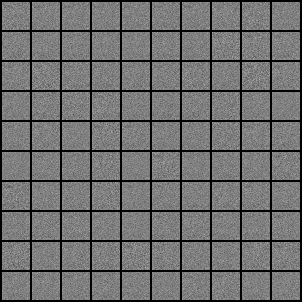

In [34]:
from torchvision.utils import save_image
import os
from IPython.display import Image

batch_size = 100
LSGAN_images_dir = "LSGAN_images_dir"


def save_lsgan_images(index):

    if not os.path.exists(LSGAN_images_dir):
        os.makedirs(LSGAN_images_dir)
    sample_vectors = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(LSGAN_images_dir, fake_fname), nrow = 10)

save_lsgan_images(0)
Image(os.path.join(LSGAN_images_dir, "fake_images-0000.png"))

In [36]:
%%time

from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_lsgan_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0102, g_loss: 0.9395, D(x): 0.98, D(G(z)): 0.04
Epoch [0/300], Step [400/600], d_loss: 0.0106, g_loss: 0.9664, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.0009, g_loss: 0.9712, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0116, g_loss: 0.9373, D(x): 0.98, D(G(z)): 0.05
Epoch [1/300], Step [400/600], d_loss: 0.0138, g_loss: 0.9625, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [600/600], d_loss: 0.1030, g_loss: 0.9238, D(x): 0.90, D(G(z)): 0.09
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0035, g_loss: 0.9914, D(x): 0.99, D(G(z)): 0.01
Epoch [2/300], Step [400/600], d_loss: 0.0111, g_loss: 0.9941, D(x): 0.97, D(G(z)): 0.00
Epoch [2/300], Step [600/600], d_loss: 0.0128, g_loss: 0.9813, D(x): 0.97, D(G(z)): 0.02
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0244, g_loss: 0.9926, D(x): 0.96, D(G(z)): 0.02
Epoch [3/300], Step [400/6

In [37]:
def save_weights_without_checkpoint(model, model_name):
    filename = f"{model_name}_weights.pth"
    torch.save(model.state_dict(), filename)
    print(f"Saved {model_name} weights to {filename}")

# Saving the Generator and Discriminator weights
save_weights_without_checkpoint(G, "Generator_new")
save_weights_without_checkpoint(D, "Discriminator_new")

Saved Generator_new weights to Generator_new_weights.pth
Saved Discriminator_new weights to Discriminator_new_weights.pth


In [38]:
G.load_state_dict(torch.load('Generator_new_weights.pth', weights_only=True))
G.eval()

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [39]:
D.load_state_dict(torch.load('Discriminator_new_weights.pth', weights_only=True))
D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [42]:
# load the weight

G.load_state_dict(torch.load("Generator_new_weights.pth", weights_only=True))
D.load_state_dict(torch.load("Discriminator_new_weights.pth", weights_only=True))

<All keys matched successfully>

In [44]:
# Re-Train 
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], d_loss: {d_loss:.4f}, '
                  f'g_loss: {g_loss:.4f}, D(x): {real_score.mean():.2f}, D(G(z)): {fake_score.mean():.2f}')
    
    save_lsgan_images(epoch+301)

Epoch [0/300], Step [200/600], d_loss: 0.2952, g_loss: 0.5921, D(x): 0.64, D(G(z)): 0.28
Epoch [0/300], Step [400/600], d_loss: 0.3843, g_loss: 0.5594, D(x): 0.60, D(G(z)): 0.33
Epoch [0/300], Step [600/600], d_loss: 0.5222, g_loss: 0.4331, D(x): 0.50, D(G(z)): 0.41
Saving fake_images-0301.png
Epoch [1/300], Step [200/600], d_loss: 0.2021, g_loss: 0.5697, D(x): 0.75, D(G(z)): 0.28
Epoch [1/300], Step [400/600], d_loss: 0.4973, g_loss: 0.3391, D(x): 0.58, D(G(z)): 0.45
Epoch [1/300], Step [600/600], d_loss: 0.3818, g_loss: 0.4354, D(x): 0.59, D(G(z)): 0.34
Saving fake_images-0302.png
Epoch [2/300], Step [200/600], d_loss: 0.2864, g_loss: 0.5054, D(x): 0.68, D(G(z)): 0.31
Epoch [2/300], Step [400/600], d_loss: 0.3603, g_loss: 0.5153, D(x): 0.61, D(G(z)): 0.32
Epoch [2/300], Step [600/600], d_loss: 0.4467, g_loss: 0.4414, D(x): 0.55, D(G(z)): 0.37
Saving fake_images-0303.png
Epoch [3/300], Step [200/600], d_loss: 0.3883, g_loss: 0.4419, D(x): 0.61, D(G(z)): 0.38
Epoch [3/300], Step [400/6

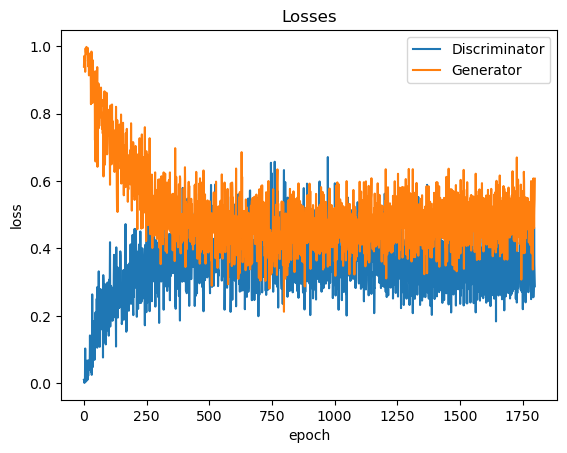

In [45]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

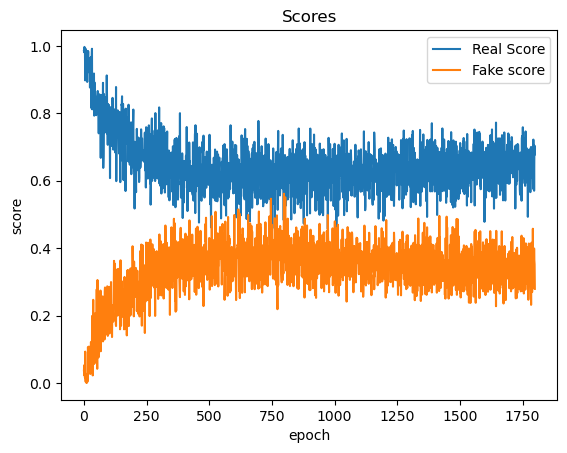

In [46]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [47]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'lsgans_training_300+300.avi'

files = [os.path.join(LSGAN_images_dir, f) for f in os.listdir(LSGAN_images_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('lsgans_training_300+300.avi')

C:\Users\pumad\OneDrive\문서\SJSU\Fall2024\DATA255\homework5\lsgans_training_300+300.avi

LSGAN final image


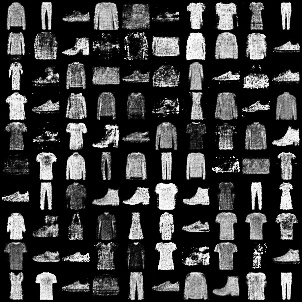

In [49]:
print("LSGAN final image")
Image("./LSGAN_images_dir/fake_images-0600.png")

GAN final image


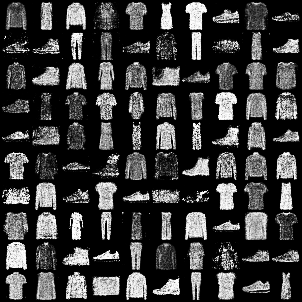

In [50]:
print("GAN final image")
Image("./modified_samples/fake_images-0300.png")

We can clearly see that after both 600 total epochs of GAN and LSGAN (by using pre-trained weights), the final image of LSGAN is more clearly captured the features of the image and shows better resolution than GAN. 